# MHW Calculation and Satellite Climatology

This notebook computes the MHW event statistics as a Python dictionary. It also generates a netcdf of the climtology and threshold values for each of the pixels in the CBay.

- Geo-Polar
- MUR
- OSTIA

- All: identify MHW, save climatology output
- Extras for just Geo-Polar: save event statistics, save threshold output, compute detrended sst and use to identify MHW

In [1]:
import os
import pickle
from typing import Union
import collections
from pathlib import Path
from datetime import datetime, date

import xarray as xr
import numpy as np
from scipy import stats
import pandas as pd
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')
REPO_ROOT = Path(REPO_ROOT)

In [3]:
# Folder in which to store processed climatologies and thresholds
OUTPUT_DIR = REPO_ROOT / 'data/02_interim'

In [4]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/'})

# client = Client(n_workers=4, memory_limit='2Gb', threads_per_worker=2)
client = Client()

2025-04-30 12:10:13,525 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:50300 (pid=2614) exceeded 95% memory budget. Restarting...
2025-04-30 12:10:14,204 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:50300' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 12, 8), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 14, 5), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 3, 5), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 5, 2), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 6, 1), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 6, 10), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 11, 6), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 10, 10), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 7, 2), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 8, 1), ('block_func-9bd0adf2e85b59266ab960a9eb0097a7', 0, 9, 8), ('block_func-9bd0adf2

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50283,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50294,Total threads: 2
Dashboard: http://127.0.0.1:50295/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50286,


### Helper functions

The processing in these functions is repeated several times throughout the notebook. That code has been consolidated here and given descriptive names to make reading the notebook easier.

In [6]:
def format_time(time_np: collections.abc.Iterable[Union[datetime, str]]) -> np.ndarray[int]:
    """
    This function converts a datetime string to an ordinal datetime. Ordinal dates
    are required for processing in the marineHeatWaves library.
    Args:
        time_np: an array of datetime strings of the format %Y-%m-%dT%H:%M:%S.000000000

    Returns:
        an array of ordinal dates (ex. 2005156)
    """
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') 
                    for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list], dtype='int32')

In [7]:
def identify_marineheatwaves(sst_np: np.ndarray, time_ordinal: np.ndarray):
    """
    This function uses the marineHeatWave package mhw.detect() and applies it
    to all the pixels in a satellite data image. The output is numpy array of
    the dictionaries that are returned from the mhw.detect() function.

    Args:
        sst_np: a 3D numpy array which gives SST values for a region. Axis 0 should
        be the time axis
        time_ordinal: a 1D numpy array which gives time values corresponding to
        sst_np in ordinal format

    Returns:
        result: A list with two items containing 1) a numpy array with a dictionary
        of marine heatwave statistics for each pixel and 2) a numpy array with the
        climatological and threshold SST for each pixel
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))
    # time_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        return mhw.detect(time, arr)
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    result = result.compute()
    return result

In [8]:
def extract_numpy_outputs(result: np.ndarray, time_length: int):
    """
    The output from mhw.detect() provides a dictionary which holds the
    climatological and threshold values for each day of the year as 1D arrays.
    This function reshapes the data from this format to a 3D numpy array of shape
    (time, lat, lon) for both climatological and threshold values.

    Args:
        result: output from a marineHeatWaves mhw.detect() function
        time_length: the number of time steps in the time series

    Result:
        two numpy arrays of shape (time, lat, lon), one containing the climatological
        SST values and the other containing the threshold SST values
    """
    # Create 2D empty output arrays
    lat_length, lon_length = result[1].shape
    climatology = np.empty((time_length, lat_length, lon_length))
    threshold = np.empty((time_length, lat_length, lon_length))

    for i in range(result[1].shape[0]):
        for j in range(result[1].shape[1]):
            climatology[:, i, j] = result[1, i, j]['seas']
            threshold[:, i, j] = result[1, i, j]['thresh']

    return climatology, threshold

In [9]:
def detrend_sst(sst_np: np.ndarray, time_ordinal: np.ndarray) -> np.ndarray:
    """
    Given a 3D numpy array of SST values this function returns an SST array with
    the long term warming signal. Long term warming is assumed to be linear.
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        def mxplusb(x, m, b):
            return m*x + b
        
        res = stats.linregress(time, arr)
        starting_temp = mxplusb(time[0], res.slope, res.intercept)
        return arr - mxplusb(time, res.slope, res.intercept) + starting_temp
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    detrended_sst = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    detrended_sst = detrended_sst.compute()
    return detrended_sst

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Geo-Polar SST**

### Open Geo-Polar SST

In [10]:
path = (
    REPO_ROOT / 'data/01_raw' /
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [11]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius',
})

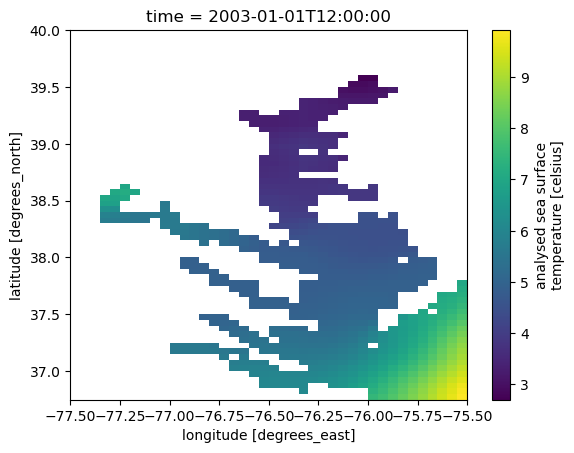

In [12]:
geopolar.isel(time=0).plot()

### Preprocessing

In [13]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

### Identify marine heatwaves with `mhw.detect()` (Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~4 minutes on my computer.

In [14]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 76.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/rwegener/repos/journalarticle_chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/repos/journalarticle_chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN sli

CPU times: user 13.6 s, sys: 4.62 s, total: 18.3 s
Wall time: 3min 54s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [15]:
event_statistics = result[0]

In [16]:
clim_np, thresh_np = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [17]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')
clim.rio.write_crs(4326, inplace=True)

<xarray.DataArray 'climatology' (time: 7663, lat: 65, lon: 40)> Size: 159MB
array([[[        nan,         nan,         nan, ...,  9.81040201,
          9.98221314, 10.14609694],
        [        nan,         nan,         nan, ...,  9.74052481,
          9.91974511, 10.09169575],
        [        nan,         nan,         nan, ...,  9.6678744 ,
          9.85478712, 10.03555855],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  9.71300365,
          9.88532026, 10.0500727 ],
        [        nan,         nan,         nan, ...,  9.64307194,
          9.82288154,  9.99577904],
        [        nan,         nan,         nan, ...,  9.57045084,
          9.75804926,  9.93981075],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  9.90965209,
         10.08094234, 10.24388489],
        [        nan,         nan,         nan, ...,  9.83991171,
         10.01851196, 10.18945448],
        [        nan,         nan,         nan, ...,  9.76726418,
          9.95345491, 10.13315662],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(7663, 65, 40))
Coordinates:
  * time         (time) datetime64[ns] 61kB 2003-01-01T12:00:00 ... 2023-12-3...
  * lat          (lat) float32 260B 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * lon          (lon) float32 160B -77.47 -77.43 -77.38 ... -75.57 -75.53
    spatial_ref  int64 8B 0
Attributes:
    comment:          climatology computed using the marineHeatWave package. ...
    source_dataset:   NOAA Geopolar
    units:            celsius
    processing_date:  2025-04-30

In [18]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_climatology_chesapeakestem.nc')

Create an xarray DataArray for the threshold data using numpy output from the MHW calculation

In [19]:
thresh = xr.DataArray(thresh_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
thresh = thresh.rename('threshold')

# add array attributes
thresh.attrs['comment'] = '90th percentile treshold values computed using the ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'
thresh.attrs['source_dataset'] = 'NOAA Geopolar'
thresh.attrs['units'] = 'celsius'
thresh.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')
thresh.rio.write_crs(4326, inplace=True)

<xarray.DataArray 'threshold' (time: 7663, lat: 65, lon: 40)> Size: 159MB
array([[[        nan,         nan,         nan, ..., 11.37748337,
         11.52586832, 11.67464333],
        [        nan,         nan,         nan, ..., 11.30193544,
         11.46722507, 11.63370926],
        [        nan,         nan,         nan, ..., 11.23712872,
         11.4106449 , 11.58444798],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., 11.28135398,
         11.42877123, 11.57657854],
        [        nan,         nan,         nan, ..., 11.20419355,
         11.36851548, 11.53532256],
        [        nan,         nan,         nan, ..., 11.13841912,
         11.30999891, 11.48541647],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., 11.47361177,
         11.62457792, 11.77786953],
        [        nan,         nan,         nan, ..., 11.39999925,
         11.56690238, 11.73725737],
        [        nan,         nan,         nan, ..., 11.33616023,
         11.5103222 , 11.68573779],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(7663, 65, 40))
Coordinates:
  * time         (time) datetime64[ns] 61kB 2003-01-01T12:00:00 ... 2023-12-3...
  * lat          (lat) float32 260B 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * lon          (lon) float32 160B -77.47 -77.43 -77.38 ... -75.57 -75.53
    spatial_ref  int64 8B 0
Attributes:
    comment:          90th percentile treshold values computed using the mari...
    source_dataset:   NOAA Geopolar
    units:            celsius
    processing_date:  2025-04-30

In [20]:
thresh.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_threshold_chesapeakestem.nc')

### Save the event statistics as a byte stream (pickle) for later processing

In [21]:
with open(OUTPUT_DIR / 'mhw_eventstats_stem_dict.pickle', 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Linearly Detrended Geo-Polar SST**

### Open Geo-Polar SST

In [23]:
path = (
    REPO_ROOT / 'data/01_raw' /
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [24]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius', 
    'valid_min': geopolar.attrs['valid_min'] - 273.15,
    'valid_max': geopolar.attrs['valid_max'] - 273.15,
})

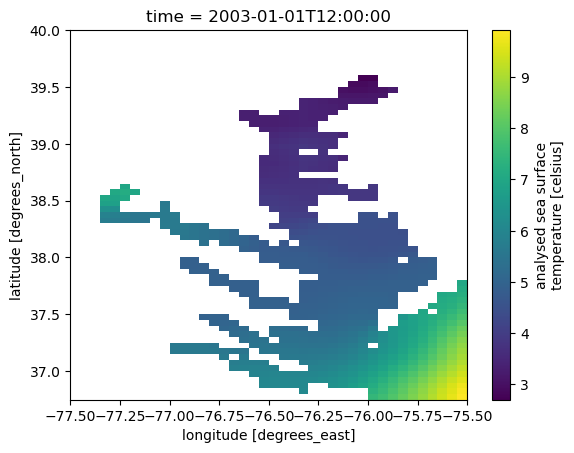

In [25]:
geopolar.isel(time=0).plot()

### Preprocessing

In [26]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

Remove long term temperature change from the SST record

In [27]:
%%time

detrended_sst_np = detrend_sst(sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 76.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.07 s, sys: 601 ms, total: 1.67 s
Wall time: 2.58 s


In [28]:
detrended_sst_np.shape

(7663, 65, 40)

### Identify marine heatwaves with `mhw.detect()` (Linearly detrended Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~3 minutes on my computer.

In [29]:
%%time

result = identify_marineheatwaves(detrended_sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 152.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rwegener/repos/journalarticle_chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])


CPU times: user 12 s, sys: 4.36 s, total: 16.3 s
Wall time: 3min 23s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [30]:
event_statistics = result[0]

In [31]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [32]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(clim_np, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing.' \
    'Input SST was linearly detrended to remove long term warming.'

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')
clim.rio.write_crs(4326, inplace=True)

<xarray.DataArray 'climatology' (time: 7663, lat: 65, lon: 40)> Size: 159MB
array([[[       nan,        nan,        nan, ..., 9.01705044,
         9.1962009 , 9.36766468],
        [       nan,        nan,        nan, ..., 8.93242548,
         9.11869113, 9.29861918],
        [       nan,        nan,        nan, ..., 8.8474286 ,
         9.04098108, 9.22968646],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 8.92188581,
         9.10152113, 9.27383219],
        [       nan,        nan,        nan, ..., 8.83724794,
         9.02408305, 9.20493539],
        [       nan,        nan,        nan, ..., 8.7523151 ,
         8.94653455, 9.13620769],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 9.11406676,
         9.29271701, 9.4632609 ],
        [       nan,        nan,        nan, ..., 9.02953711,
         9.21520259, 9.39414489],
        [       nan,        nan,        nan, ..., 8.9445083 ,
         9.1373575 , 9.32501553],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], shape=(7663, 65, 40))
Coordinates:
  * time         (time) datetime64[ns] 61kB 2003-01-01T12:00:00 ... 2023-12-3...
  * lat          (lat) float32 260B 36.78 36.83 36.88 ... 39.88 39.92 39.97
  * lon          (lon) float32 160B -77.47 -77.43 -77.38 ... -75.57 -75.53
    spatial_ref  int64 8B 0
Attributes:
    comment:          climatology computed using the marineHeatWave package. ...
    source_dataset:   NOAA Geopolar
    units:            celsius
    processing_date:  2025-04-30

In [33]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_climatology_chesapeakestem_detrended.nc')

### Save the event statistics as a byte stream (pickle) for later processing

In [34]:
with open(OUTPUT_DIR / 'mhw_eventstats_stem_dict_detrended.pickle', 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **MUR SST**

### Open MUR SST

In [37]:
path = (
    REPO_ROOT / 'data/01_raw' / 
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-CB-20030101_20231231.nc'
)
mur = xr.open_dataset(path).analysed_sst

In [38]:
# convert kelvin to celsius & update metadata
mur.values = mur.values - 273.15
mur.attrs.update({
    'units': 'celsius', 
})

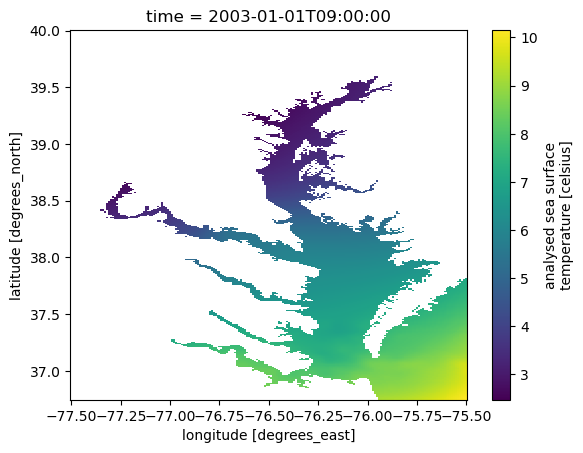

In [39]:
mur.isel(time=0).plot()

### Preprocessing

In [40]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(mur.time.values)
# Extract numpy array from xarray DataArray
sst_np = mur.values.astype('float16')

### Identify marine heatwaves with `mhw.detect()` (MUR)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in 80 minutes on my computer.

In [41]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 0.94 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-04-30 12:09:53,559 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.07 GiB -- Worker memory limit: 4.00 GiB
2025-04-30 12:09:54,006 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.23 GiB -- Worker memory limit: 4.00 GiB
2025-04-30 12:09:57,122 - distributed

KilledWorker: Attempted to run task 'finalize-hlgfinalizecompute-0927df933b394509af154a4794e55f93' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:50294. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [42]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from MUR is ignored since it is not used

ValueError: could not broadcast input array from shape (7663,) into shape (7667,)

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = mur.coords, dims=mur.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NASA MUR'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')
clim.rio.write_crs(4326, inplace=True)

In [ ]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'mur_climatology_chesapeakestem.nc')

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **OSTIA SST**

Restart kernel before running OSTIA

### Open OSTIA SST

In [ ]:
path = (
    REPO_ROOT / 'data/01_raw' / 
    'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_CBstem_2007-01-01-2023-12-31.nc'
)
ostia = xr.open_dataset(path).analysed_sst

In [ ]:
# convert kelvin to celsius & update metadata
ostia.values = ostia.values - 273.15
ostia.attrs.update({
    'units': 'celsius', 
})

In [ ]:
ostia.isel(time=0).plot()

### Preprocessing

In [ ]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(ostia.time.values)
# Extract numpy array from xarray DataArray
sst_np = ostia.values

### Identify marine heatwaves with `mhw.detect()` (OSTIA)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in 4 minutes on my computer.

In [ ]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [ ]:
event_statistics = result[0]

In [ ]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from OSTIA is ignored since it is not used

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = ostia.coords, dims=ostia.dims)
clim = clim.rename({'latitude': 'lat', 'longitude': 'lon'})

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'Copernicus OSTIA'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')
clim.rio.write_crs(4326, inplace=True)

In [ ]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'ostia_climatology_chesapeakestem.nc')